📊 Loading Sonar Dataset...
✅ Loaded from fallback URL.
Class distribution before augmentation: {np.int64(0): np.int64(89), np.int64(1): np.int64(77)}
Augmenting minority class 1...
Class distribution after augmentation: {np.int64(0): np.int64(89), np.int64(1): np.int64(308)}
Augmentation applied: Original (166, 60) -> Augmented (397, 60)

🧪 Training XGBoost with 5-Fold Cross Validation...
🔍 Tuning XGBoost hyperparameters...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
XGBoost Hold-out Test Accuracy: 0.9524
              precision    recall  f1-score   support

           M       0.92      1.00      0.96        22
           R       1.00      0.90      0.95        20

    accuracy                           0.95        42
   macro avg       0.96      0.95      0.95        42
weighted avg       0.96      0.95      0.95        42



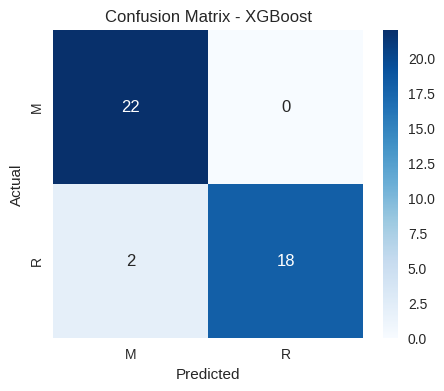


🧪 Training SVM with 5-Fold Cross Validation...
🔍 Tuning SVM hyperparameters...
Best Parameters for SVM: {'C': 1.0, 'gamma': 'scale'}
SVM Hold-out Test Accuracy: 0.9048
              precision    recall  f1-score   support

           M       0.91      0.91      0.91        22
           R       0.90      0.90      0.90        20

    accuracy                           0.90        42
   macro avg       0.90      0.90      0.90        42
weighted avg       0.90      0.90      0.90        42



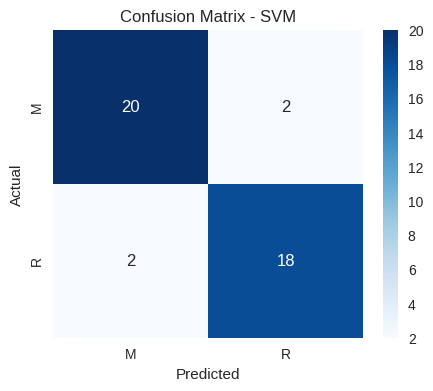


🧪 Training Random Forest with 5-Fold Cross Validation...
🔍 Tuning Random Forest hyperparameters...
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Hold-out Test Accuracy: 0.9762
              precision    recall  f1-score   support

           M       1.00      0.95      0.98        22
           R       0.95      1.00      0.98        20

    accuracy                           0.98        42
   macro avg       0.98      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42



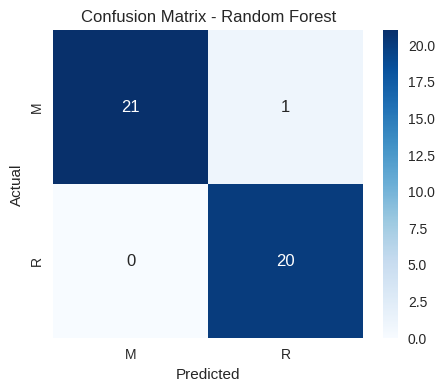

<ipython-input-14-2062364864>:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")


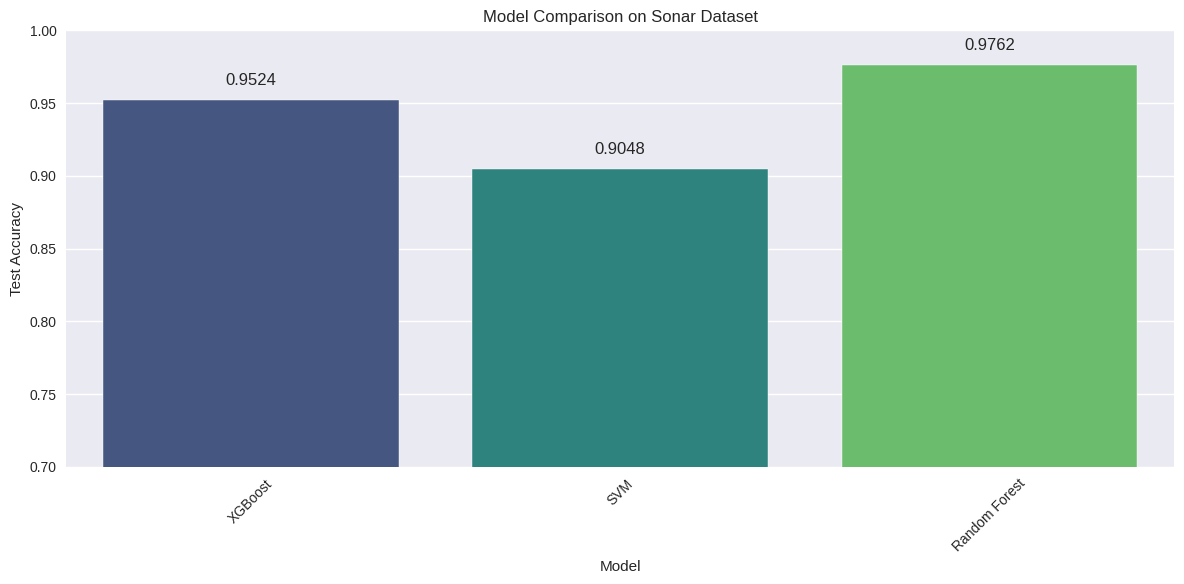


FINAL RESULTS SUMMARY
XGBoost             : 0.9524
SVM                 : 0.9048
Random Forest       : 0.9762


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

# Set random seeds for reproducibility
np.random.seed(42)
import random
random.seed(42)

sns.set_palette("husl")
plt.style.use('seaborn-v0_8')

def load_data():
    print("📊 Loading Sonar Dataset...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
    columns = [f'feature_{i+1}' for i in range(60)] + ['class']
    data = pd.read_csv(url, header=None, names=columns)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    print("✅ Loaded from fallback URL.")
    return X, y

def preprocess_data(X, y):
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, le

def augment_minority_class(X, y, minority_class_label, n_augmentations=5, noise_level=0.01, random_state=42):
    """Fixed augmentation with proper random state control"""
    # Set local random state for this function
    np.random.seed(random_state)

    X_minority = X[y == minority_class_label]
    augmented_samples = []
    for i in range(n_augmentations):
        # Use different seed for each augmentation to ensure variety while maintaining reproducibility
        np.random.seed(random_state + i)
        noise = np.random.normal(loc=0, scale=noise_level, size=X_minority.shape)
        augmented = X_minority + noise
        augmented_samples.append(augmented)

    X_augmented = np.vstack(augmented_samples)
    y_augmented = np.full(shape=(X_augmented.shape[0],), fill_value=minority_class_label)
    X_combined = np.vstack((X, X_augmented))
    y_combined = np.hstack((y, y_augmented))
    return X_combined, y_combined

def train_and_evaluate_all(X_train, X_test, y_train, y_test, le, n_splits=5):
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.01]
        },
        'SVM': {
            'C': [0.1, 1.0],
            'gamma': ['scale', 'auto']
        }
    }

    # All models now have explicit random_state
    models = {
        'XGBoost': XGBClassifier(
            n_estimators=150,
            max_depth=4,
            learning_rate=0.1,
            subsample=0.7,
            colsample_bytree=0.9,
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42  # This was already set
        ),
        'SVM': SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            random_state=42  # This was already set
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=300,
            max_depth=16,
            min_samples_split=2,
            min_samples_leaf=1,
            class_weight='balanced_subsample',
            random_state=42  # This was already set
        ),
    }

    results = {}
    # Fixed random_state in StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, model in models.items():
        print(f"\n🧪 Training {name} with {n_splits}-Fold Cross Validation...")

        if name in param_grids:
            print(f"🔍 Tuning {name} hyperparameters...")
            param_grid = param_grids[name]

            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                scoring='accuracy',
                cv=skf,  # Uses the same CV split for all models
                n_jobs=-1,
                verbose=0
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            print(f"Best Parameters for {name}: {grid_search.best_params_}")
        else:
            best_model = model
            best_model.fit(X_train, y_train)

        y_pred = best_model.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred)
        results[name] = test_acc
        print(f"{name} Hold-out Test Accuracy: {test_acc:.4f}")
        print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    return results

def plot_results(results):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
    plt.ylim(0.7, 1.0)
    plt.title('Model Comparison on Sonar Dataset')
    plt.ylabel('Test Accuracy')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    for index, value in enumerate(results.values()):
        plt.text(index, value + 0.01, f"{value:.4f}", ha='center')
    plt.tight_layout()
    plt.show()

def main():
    # Set seeds at the beginning of main execution
    np.random.seed(42)
    random.seed(42)

    X, y = load_data()
    X_train, X_test, y_train, y_test, le = preprocess_data(X, y)

    unique, counts = np.unique(y_train, return_counts=True)
    class_counts = dict(zip(unique, counts))
    majority_class = max(class_counts, key=class_counts.get)
    minority_class = min(class_counts, key=class_counts.get)

    print(f"Class distribution before augmentation: {class_counts}")
    print(f"Augmenting minority class {minority_class}...")

    X_train_aug, y_train_aug = augment_minority_class(
        X_train, y_train,
        minority_class_label=minority_class,
        n_augmentations=3,
        noise_level=0.01,
        random_state=42  # Added explicit random_state
    )

    unique_aug, counts_aug = np.unique(y_train_aug, return_counts=True)
    class_counts_aug = dict(zip(unique_aug, counts_aug))
    print(f"Class distribution after augmentation: {class_counts_aug}")
    print(f"Augmentation applied: Original {X_train.shape} -> Augmented {X_train_aug.shape}")

    results = train_and_evaluate_all(X_train_aug, X_test, y_train_aug, y_test, le)
    plot_results(results)

    # Print final results summary
    print("\n" + "="*50)
    print("FINAL RESULTS SUMMARY")
    print("="*50)
    for model, accuracy in results.items():
        print(f"{model:20s}: {accuracy:.4f}")

if __name__ == "__main__":
    main()

📊 Loading Sonar Dataset...
✅ Loaded from fallback URL.
Class distribution before augmentation: {np.int64(0): np.int64(89), np.int64(1): np.int64(77)}
Augmenting minority class 1...
Class distribution after augmentation: {np.int64(0): np.int64(89), np.int64(1): np.int64(308)}
Augmentation applied: Original (166, 60) -> Augmented (397, 60)

🧪 Training XGBoost with 5-Fold Cross Validation...
🔍 Tuning XGBoost hyperparameters...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:38:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
XGBoost Mean CV Accuracy: 0.9597
XGBoost Hold-out Test Accuracy: 0.9524
              precision    recall  f1-score   support

           M       0.92      1.00      0.96        22
           R       1.00      0.90      0.95        20

    accuracy                           0.95        42
   macro avg       0.96      0.95      0.95        42
weighted avg       0.96      0.95      0.95        42



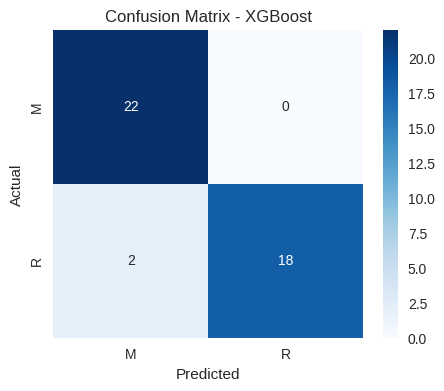


🧪 Training SVM with 5-Fold Cross Validation...
🔍 Tuning SVM hyperparameters...
Best Parameters for SVM: {'C': 1.0, 'gamma': 'scale'}
SVM Mean CV Accuracy: 0.9571
SVM Hold-out Test Accuracy: 0.9048
              precision    recall  f1-score   support

           M       0.91      0.91      0.91        22
           R       0.90      0.90      0.90        20

    accuracy                           0.90        42
   macro avg       0.90      0.90      0.90        42
weighted avg       0.90      0.90      0.90        42



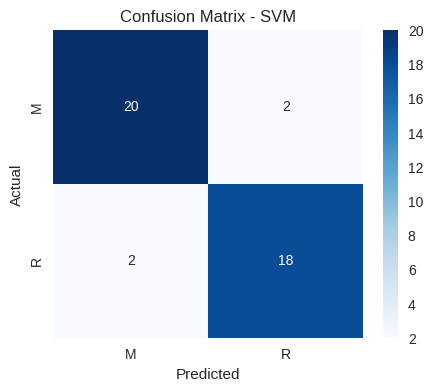


🧪 Training Random Forest with 5-Fold Cross Validation...
🔍 Tuning Random Forest hyperparameters...
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Mean CV Accuracy: 0.9471
Random Forest Hold-out Test Accuracy: 0.9762
              precision    recall  f1-score   support

           M       1.00      0.95      0.98        22
           R       0.95      1.00      0.98        20

    accuracy                           0.98        42
   macro avg       0.98      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42



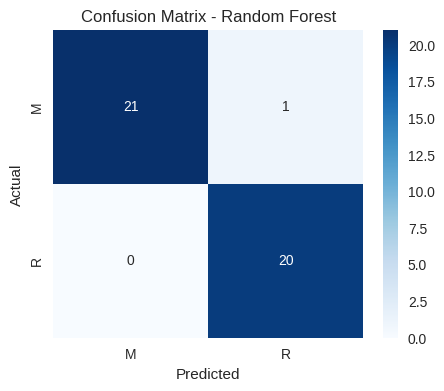

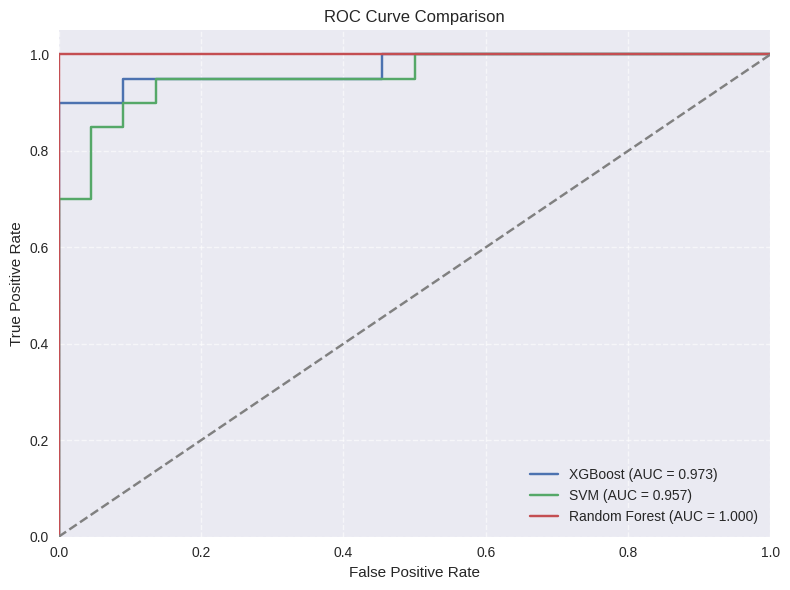

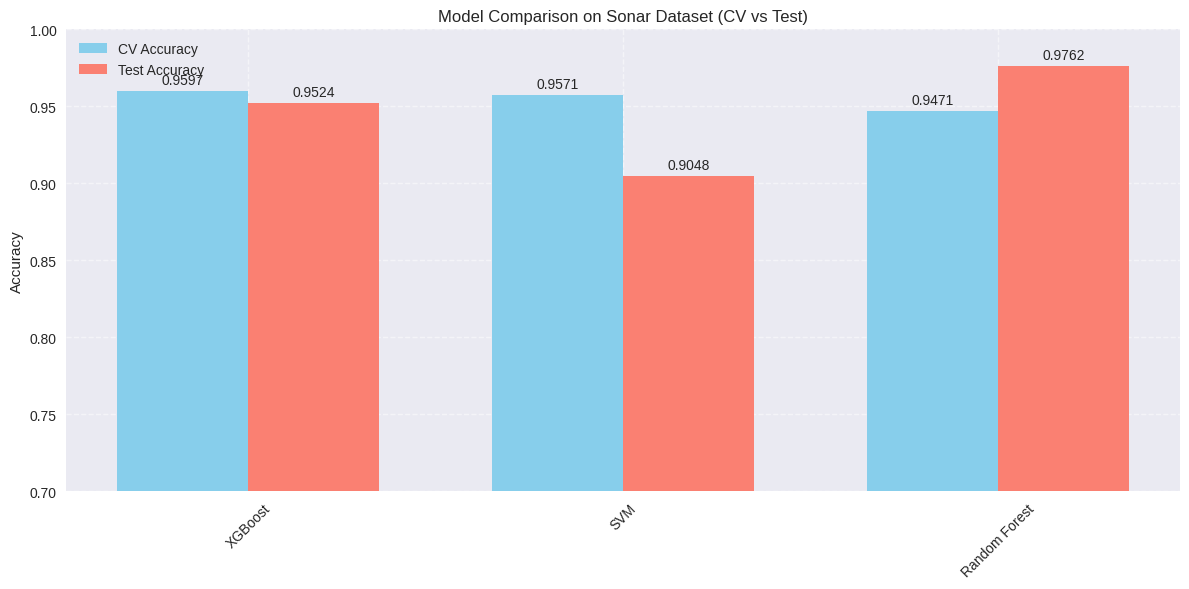


FINAL RESULTS SUMMARY
XGBoost             : CV=0.9597, Test=0.9524
SVM                 : CV=0.9571, Test=0.9048
Random Forest       : CV=0.9471, Test=0.9762


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

sns.set_palette("husl")
plt.style.use('seaborn-v0_8')

def load_data():
    print("📊 Loading Sonar Dataset...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
    columns = [f'feature_{i+1}' for i in range(60)] + ['class']
    data = pd.read_csv(url, header=None, names=columns)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    print("✅ Loaded from fallback URL.")
    return X, y

def preprocess_data(X, y):
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, le

def augment_minority_class(X, y, minority_class_label, n_augmentations=5, noise_level=0.01, random_state=42):
    """Fixed augmentation with proper random state control"""
    # Set local random state for this function
    np.random.seed(random_state)

    X_minority = X[y == minority_class_label]
    augmented_samples = []
    for i in range(n_augmentations):
        # Use different seed for each augmentation to ensure variety while maintaining reproducibility
        np.random.seed(random_state + i)
        noise = np.random.normal(loc=0, scale=noise_level, size=X_minority.shape)
        augmented = X_minority + noise
        augmented_samples.append(augmented)

    X_augmented = np.vstack(augmented_samples)
    y_augmented = np.full(shape=(X_augmented.shape[0],), fill_value=minority_class_label)
    X_combined = np.vstack((X, X_augmented))
    y_combined = np.hstack((y, y_augmented))
    return X_combined, y_combined

def train_and_evaluate_all(X_train, X_test, y_train, y_test, le, n_splits=5):
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.01]
        },
        'SVM': {
            'C': [0.1, 1.0],
            'gamma': ['scale', 'auto']
        }
    }

    models = {
        'XGBoost': XGBClassifier(
            n_estimators=150,
            max_depth=4,
            learning_rate=0.1,
            subsample=0.7,
            colsample_bytree=0.9,
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        ),
        'SVM': SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            probability=True,      # for ROC curve
            random_state=42
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=300,
            max_depth=16,
            min_samples_split=2,
            min_samples_leaf=1,
            class_weight='balanced_subsample',
            random_state=42
        ),
    }

    results = {}
    cv_results = {}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    roc_dict = {}

    for name, model in models.items():
        print(f"\n🧪 Training {name} with {n_splits}-Fold Cross Validation...")

        if name in param_grids:
            print(f"🔍 Tuning {name} hyperparameters...")
            param_grid = param_grids[name]

            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                scoring='accuracy',
                cv=skf,
                n_jobs=-1,
                verbose=0
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            print(f"Best Parameters for {name}: {grid_search.best_params_}")

            # Store mean cross-validation accuracy
            best_score = grid_search.best_score_
            cv_results[name] = best_score
            print(f"{name} Mean CV Accuracy: {best_score:.4f}")
        else:
            best_model = model
            best_model.fit(X_train, y_train)

            # Manual cross-validation for models without grid search
            scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='accuracy')
            best_score = scores.mean()
            cv_results[name] = best_score
            print(f"{name} Mean CV Accuracy: {best_score:.4f}")

        y_pred = best_model.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred)
        results[name] = test_acc
        print(f"{name} Hold-out Test Accuracy: {test_acc:.4f}")
        print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # ROC curve (binary classification)
        if hasattr(best_model, "predict_proba"):
            y_proba = best_model.predict_proba(X_test)[:, 1]
        elif hasattr(best_model, "decision_function"):
            y_proba = best_model.decision_function(X_test)
            # Scale decision_function to [0,1] for ROC AUC
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-8)
        else:
            y_proba = None

        if y_proba is not None and len(le.classes_) == 2:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            roc_dict[name] = (fpr, tpr, roc_auc)

    # Plot ROC curve for all models
    if len(roc_dict) > 0:
        plt.figure(figsize=(8, 6))
        for name, (fpr, tpr, roc_auc) in roc_dict.items():
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Comparison')
        plt.legend(loc="lower right")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    return {'cv': cv_results, 'test': results}

def plot_results(results):
    models = list(results['test'].keys())
    test_scores = list(results['test'].values())
    cv_scores = list(results['cv'].values())

    x = np.arange(len(models))  # label locations
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, cv_scores, width, label='CV Accuracy', color='skyblue')
    rects2 = ax.bar(x + width/2, test_scores, width, label='Test Accuracy', color='salmon')

    ax.set_ylim(0.7, 1.0)
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Comparison on Sonar Dataset (CV vs Test)')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

def main():
    # Set seeds at the beginning of main execution
    np.random.seed(42)
    random.seed(42)

    X, y = load_data()
    X_train, X_test, y_train, y_test, le = preprocess_data(X, y)

    unique, counts = np.unique(y_train, return_counts=True)
    class_counts = dict(zip(unique, counts))
    majority_class = max(class_counts, key=class_counts.get)
    minority_class = min(class_counts, key=class_counts.get)

    print(f"Class distribution before augmentation: {class_counts}")
    print(f"Augmenting minority class {minority_class}...")

    X_train_aug, y_train_aug = augment_minority_class(
        X_train, y_train,
        minority_class_label=minority_class,
        n_augmentations=3,
        noise_level=0.01,
        random_state=42
    )

    unique_aug, counts_aug = np.unique(y_train_aug, return_counts=True)
    class_counts_aug = dict(zip(unique_aug, counts_aug))
    print(f"Class distribution after augmentation: {class_counts_aug}")
    print(f"Augmentation applied: Original {X_train.shape} -> Augmented {X_train_aug.shape}")

    results_dict = train_and_evaluate_all(X_train_aug, X_test, y_train_aug, y_test, le)
    plot_results(results_dict)

    # Print final results summary
    print("\n" + "="*50)
    print("FINAL RESULTS SUMMARY")
    print("="*50)
    for model in results_dict['test']:
        print(f"{model:20s}: CV={results_dict['cv'][model]:.4f}, Test={results_dict['test'][model]:.4f}")

if __name__ == "__main__":
    main()